In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import glob
from ctp_tools.ctp import *

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 20]

# Introduction

This is an __example__ of generating head CT perfusion map from series of CT scans by cSVD-based deconvolution.

**THE ALGORITHM HAS NOT BEEN VALIDATED AND IS NOT INTENDED FOR CLINICAL USAGE**

# CTP: a step-by-step tutorial

## Step 1: DICOM read-in and preprocessing

Head CT perfusion scans are 4D CT scans at short time intervals covering the whole time course of contrast agent inflow and outflow. These scans are typically stacked in one series. You need to identify one or some combination of Dicom tags that can indicate the time of each head scan so that we can split the series into T*3D scans of each time slice.

If no Dicom tag can be used for slicing, typically each time slice has identical image count, you can make use of this by setting `fixedInterval={image_count}`.

You can check the output by `viewImDiagnostic`. Each slice should be identical in position in the diagnostic image.

In [2]:
imLst, timeIndex = readCTPSeries(glob.glob('ctp_example/301/*.dcm'), 
                                 refTime=None, # use "AcquisitionTime" or "ContentTime" if applicable
                                 fixedInterval=32 # if no dicom tags can be used as time indicator
                                )

/home/agnimon/miniconda3/envs/dev3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
# Not necessary if refTime is not None 
scanInterval = 2.0 # seconds
timeIndex *= scanInterval

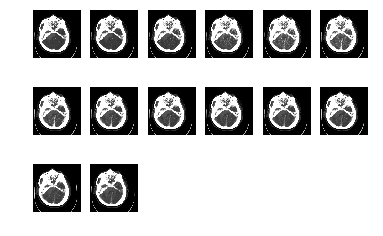

In [4]:
viewImDiagnostic(imLst)

## Step 2: Image preprocessing

In [5]:
# Smooth the input image while keeping edges intact
# You can also try out other filters
imFil = [sitk.CurvatureFlow(i, numberOfIterations=50) for i in imLst]

# Get brain mask

brainMask = getBrainmask(imFil[0])

## Step 3: Concentration Time Curve (CTC) Generation

In [6]:
imCTC, s0Index = getCTC(imFil, brainMask) # returns nparray

## Step 4: TTP (Time-to-peak) map generation

In [7]:
TTP = runTTP(imCTC, timeIndex, s0Index, brainMask)

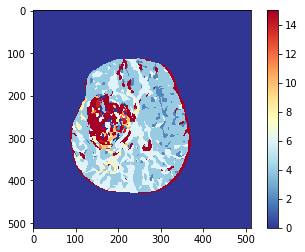

In [8]:
plt.imshow(TTP[20], cmap=plt.cm.RdYlBu_r, vmin=0, vmax=15)
plt.colorbar()

## Step 5: Arterial input function (AIF) fitting

Adjust `TTPThres` (typically 4-12) and `AUCThres` (typically a few hundreds) for better AIF region-of-interest selection. You can also use `roi` parameter to limit the search region.

AIF evaluation point should be placed within large artery (usually carotid artery or M1 segment of middle cerebral artery). Use diagnostic image to check if the point is placed properly and check the goodness of curve fitting

/home/agnimon/miniconda3/envs/dev3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


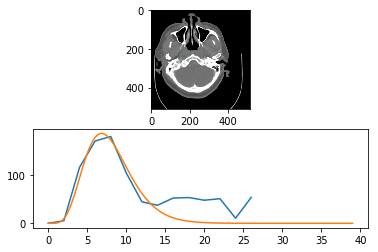

In [9]:
aifProps, aifCandSeg, scores = runAIF(imCTC, timeIndex, brainMask, TTP, 
                                      TTPThres=10, AUCThres=1000,
                                      roi=None)
    # use this to limit the search region
                                      # roi=[0, 0, 5, 512, 512, 10]) 

viewAIFDiagnosticImage(imLst, timeIndex, imCTC, s0Index, aifProps, aifCandSeg)

## Step 6: cSVD based deconvolution

In [10]:
MTT, CBV, CBF = runDeconv(imCTC, timeIndex, brainMask, aifProps)

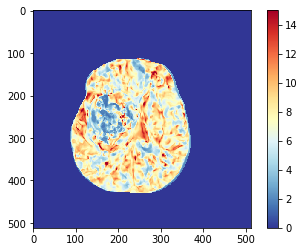

In [11]:
plt.imshow(MTT[20], cmap=plt.cm.RdYlBu_r, vmin=0, vmax=15)
plt.colorbar()

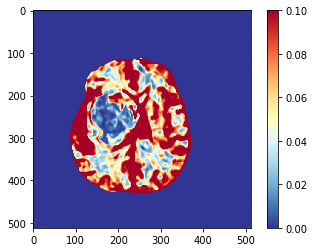

In [12]:
plt.imshow(CBV[20], cmap=plt.cm.RdYlBu_r, vmin=0, vmax=0.1)
plt.colorbar()

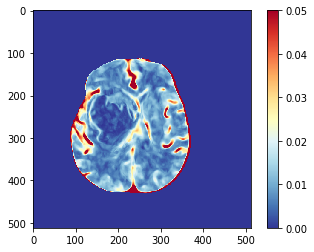

In [13]:
plt.imshow(CBF[20], cmap=plt.cm.RdYlBu_r, vmin=0, vmax=0.05)
plt.colorbar()

## Step 7: Save output as nii files

In [14]:
TTP_im = sitk.GetImageFromArray(TTP)
TTP_im.CopyInformation(imLst[0])

MTT_im = sitk.GetImageFromArray(MTT)
MTT_im.CopyInformation(imLst[0])

CBV_im = sitk.GetImageFromArray(CBV)
CBV_im.CopyInformation(imLst[0])

CBF_im = sitk.GetImageFromArray(CBF)
CBF_im.CopyInformation(imLst[0])

In [15]:
sitk.WriteImage(TTP_im, 'TTP.nii.gz')
sitk.WriteImage(MTT_im, 'MTT.nii.gz')
sitk.WriteImage(CBV_im, 'CBV.nii.gz')
sitk.WriteImage(CBF_im, 'CBF.nii.gz')